In [86]:
import os
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import plot
from scipy import stats
from scipy.stats import zscore


In [87]:
# Constants
BASE_FOLDER = 'probanten'
PARTICIPANTS = ['01', '02', '03', '04', '07', '08', '09', '10', '11']
SENSOR_FILES = ['accelerometer_data', 'gyroscope_data', 'magnetometer_data', 'user_accelerometer_data']
SPEED_FILE = 'speed_data'
STARTING_TIMESTAMPS = {
    '01': 1720610204501,
    '02': 1720611503602,
    '03': 1720612727640,
    '04': 1720613776577,
    '05': 1720614956563,
    '06': 1720617727299,
    '07': 1720621234414,
    '08': 1720622424927,
    '09': 1720623626949,
    '10': 1720624816427,
    '11': 1720625936732
}

GROUP_E = [1,0,2,0,2,1]
GROUP_B = [1,1,1,1,1,1]
GROUP_F = [2,2,2,0,2,2]

PROMPT_LABELS = {
    '01': GROUP_E,
    '02': GROUP_B,
    '03': GROUP_F,
    '04': GROUP_E,
    '05': GROUP_B,
    '06': GROUP_F,
    '07': GROUP_E,
    '08': GROUP_B,
    '09': GROUP_F,
    '10': GROUP_E,
    '11': GROUP_B
}


allaverages = []
positive_averages = []
negative_averages = []
neutral_averages = []


In [88]:
def load_sensor_data(participant, sensor_file):
    file_path = os.path.join(BASE_FOLDER, participant, sensor_file)
    df = pd.read_csv(file_path, header=None, names=['time', 'x', 'y', 'z'])
    # Add column to identify the type of sensor (accelorometer, magnetometer, etc.)
    # Removes "_data" from the string to make it look nicer
    df['sensor'] = sensor_file.split('_')[0]
    return df

def load_all_sensor_data(participant):
    dfs = [load_sensor_data(participant, sensor_file) for sensor_file in SENSOR_FILES]
    return pd.concat(dfs)

def load_speed_data(participant):
    file_path = os.path.join(BASE_FOLDER, participant, SPEED_FILE)
    df = pd.read_csv(file_path, header=None, names=['time', 'speed'])
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    # Converting to km/h from m/s
    df['speed'] = df['speed'] * 3.6 
    return df


In [89]:
# Clean up speed data
def clean_speed_data(df, upper_threshold, lower_threshold):
    
    df = df[df['speed'] <= upper_threshold]    
    df = df[df['speed'] >= lower_threshold]    
    return df

In [90]:
def plot_sensor_data(df, participant):
    fig = go.Figure()
    sensors = df['sensor'].unique()
    for sensor in sensors:
        sensor_data = df[df['sensor'] == sensor]
        fig.add_trace(go.Scatter(x=pd.to_datetime(sensor_data['time'], unit='ms'), y=sensor_data['x'], mode='lines', name=f'{sensor}_x'))
        fig.add_trace(go.Scatter(x=pd.to_datetime(sensor_data['time'], unit='ms'), y=sensor_data['y'], mode='lines', name=f'{sensor}_y'))
        fig.add_trace(go.Scatter(x=pd.to_datetime(sensor_data['time'], unit='ms'), y=sensor_data['z'], mode='lines', name=f'{sensor}_z'))
    add_time_markers(df, fig, 'sensor', participant)
    fig.update_layout(title=f'Sensor Data for Participant {participant}', xaxis_title='Time', yaxis_title='Sensor Value', xaxis=dict(tickformat='%H:%M'))
    fig.show()

def plot_speed_data(df, participant):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pd.to_datetime(df['time'], unit='ms'), y=df['speed'], mode='lines', name='Speed'))
    add_time_markers(df, fig, 'speed', participant)
    fig.update_layout(title=f'Speed Data for Participant {participant}', xaxis_title='Time', yaxis_title='Speed in km/h', xaxis=dict(tickformat='%H:%M'))
    fig.show()

def plot_average_speeds(averages, participant):
    # To explain zip(*variable):
    # * operator unpacks lists into individual tupels
    # -> it turns [(a,b,c), (d,e,f), ...] into (a,c,b), (d,e,f), ...
    # useful because zip takes in tupels
    #
    # zip groups elements from tupels:
    # zip(
    # (a,b,c),
    # (a,b,c),
    # (a,b,c))
    #   returns
    # [(a,a,a), (b,b,b), (c,c,c)]
    markers, avg_before, avg_after = zip(*averages)
    fig = go.Figure()
    # At each marker we plot the average speed before and after
    fig.add_trace(go.Scatter(x=markers, y=avg_before, mode='lines+markers', name='Average Speed Before Marker (km/h)'))
    fig.add_trace(go.Scatter(x=markers, y=avg_after, mode='lines+markers', name='Average Speed After Marker (km/h)'))
    fig.update_layout(title=f'Average Speed Before and After Markers for Participant {participant}', 
                      xaxis_title='Time', yaxis_title='Average Speed (km/h)', xaxis=dict(tickformat='%H:%M'))
    fig.show()

def plot_percentage_changes(percentage_changes, participant):
    markers, percent_changes = zip(*percentage_changes)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=markers, y=percent_changes, mode='lines+markers', name='Percentage Change'))
    
    fig.update_layout(title=f'Percentage Change in Speed After Markers for Participant {participant}', 
                      xaxis_title='Time', yaxis_title='Percentage Change (%)', xaxis=dict(tickformat='%H:%M'))
    fig.show()

# Function to create the vertical dashes to indicate the time where the audio prompts where played to the participants
def add_time_markers(df, fig, data, participant):
    starting_time = pd.to_datetime(STARTING_TIMESTAMPS[participant], unit='ms')
    labels = PROMPT_LABELS[participant]
    
    fig.add_vline(x=starting_time, line=dict(color='red', dash='dash'))
    fig.add_annotation(x=starting_time, y=max(df[data]), text='Start', showarrow=True, arrowhead=1, ax=-10, ay=-30, arrowcolor='red')
    
    for i in range(1, 7):
        marker_time = starting_time + pd.Timedelta(minutes=2 * i)
        color = 'green' if labels[i-1] == 1 else 'blue' if labels[i-1] == 2 else 'grey'
        fig.add_vline(x=marker_time, line=dict(color=color, dash='dash'))
        fig.add_annotation(x=marker_time, y=max(df[data]), text=f'+{2 * i}min', showarrow=True, arrowhead=1, ax=-10, ay=-30, arrowcolor=color)
    
    marker_time = starting_time + pd.Timedelta(minutes=15)
    fig.add_vline(x=marker_time, line=dict(color='red', dash='dash'))
    fig.add_annotation(x=marker_time, y=max(df[data]), text='End', showarrow=True, arrowhead=1, ax=-10, ay=-30, arrowcolor='blue')



In [91]:
# Calculate average speed before and after each marker
# Starting time is the starting timestamp of each run
def calculate_average_speeds(df, starting_time):
    averages = []
    # Defines the markers at each audio prompt (every two minutes, 6 times)
    markers = [starting_time + pd.Timedelta(minutes=2 * i) for i in range(1, 7)]
    
    for marker in markers:
        # Get the timestamp before and after
        before_start = marker - pd.Timedelta(minutes=1)
        after_end = marker + pd.Timedelta(minutes=1)
        
        # Calculate the mean value of all speed values before and after the marker
        avg_before = df[(df['time'] >= before_start) & (df['time'] < marker)]['speed'].mean()
        avg_after = df[(df['time'] >= marker) & (df['time'] < after_end)]['speed'].mean()
        
        # Appends it to the list to return afterwards
        averages.append((marker, avg_before, avg_after))
    
    return averages

# Calculate the ratio of average before and average after
# Input is the output of calculate_average_speeds
def calculate_percentage_changes(averages):
    percentage_changes = []

    for marker, avg_before, avg_after in averages:
        
        # Safety handling division by 0
        if avg_before != 0:
            # Calc percentage change of average before compared to after
            percent_change = ((avg_after - avg_before) / avg_before) * 100
        else:
            percent_change = 0 
        
        # Append to list and return afterwards
        percentage_changes.append((marker, percent_change))
    
    return percentage_changes

def remove_outliers_zscore(df, threshold=3):
    z_scores = zscore(df['speed'])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < threshold)
    return df[filtered_entries]

def remove_outliers_iqr(df):
    Q1 = df['speed'].quantile(0.25)
    Q3 = df['speed'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df['speed'] >= lower_bound) & (df['speed'] <= upper_bound)]

In [92]:

for participant in PARTICIPANTS:
    # Sensor data
    sensor_df = load_all_sensor_data(participant)
    # plot_sensor_data(sensor_df, participant)
    
    # Speed data
    speed_df = load_speed_data(participant)
    cleaned_speed_df = clean_speed_data(speed_df, 20, 5)
    # Usage
    cleaned_speed_df = remove_outliers_zscore(cleaned_speed_df)
    plot_speed_data(cleaned_speed_df, participant)

    # Average speeds
    starting_time = pd.to_datetime(STARTING_TIMESTAMPS[participant], unit='ms')
    averages = calculate_average_speeds(cleaned_speed_df, starting_time)

    labels = PROMPT_LABELS[participant]
    
    pos_avgs = [avg for avg, label in zip(averages, labels) if label == 1]
    neg_avgs = [avg for avg, label in zip(averages, labels) if label == 2]
    neu_avgs = [avg for avg, label in zip(averages, labels) if label == 0]
    
    positive_averages.append(pos_avgs)
    negative_averages.append(neg_avgs)
    neutral_averages.append(neu_avgs)

    print(averages)
    print(len(averages))
    print(len(pos_avgs))
    print(len(neg_avgs))
    print(len(neu_avgs))
    allaverages.append(averages)
    # plot_average_speeds(averages, participant)
    
    # Percentage changes
    percentage_changes = calculate_percentage_changes(averages)
    # plot_percentage_changes(percentage_changes, participant)
print(len(allaverages))

[(Timestamp('2024-07-10 11:18:44.501000'), np.float64(10.458000068664552), np.float64(10.976000022888183)), (Timestamp('2024-07-10 11:20:44.501000'), np.float64(11.195999965667728), np.float64(11.240999794006347)), (Timestamp('2024-07-10 11:22:44.501000'), np.float64(11.245090874758635), np.float64(12.591999912261963)), (Timestamp('2024-07-10 11:24:44.501000'), np.float64(13.052000045776367), np.float64(12.873599824905394)), (Timestamp('2024-07-10 11:26:44.501000'), np.float64(12.420000171661378), np.float64(12.67199993133545)), (Timestamp('2024-07-10 11:28:44.501000'), np.float64(12.168000030517579), np.float64(11.779999923706054))]
6
2
2
2


[(Timestamp('2024-07-10 11:40:23.602000'), np.float64(8.131500077247619), np.float64(8.17199993133545)), (Timestamp('2024-07-10 11:42:23.602000'), np.float64(7.794000034332276), np.float64(8.180000019073486)), (Timestamp('2024-07-10 11:44:23.602000'), np.float64(8.31200008392334), np.float64(8.271999835968018)), (Timestamp('2024-07-10 11:46:23.602000'), np.float64(9.19440007209778), np.float64(9.33119994163513)), (Timestamp('2024-07-10 11:48:23.602000'), np.float64(9.179999828338623), np.float64(8.976000118255616)), (Timestamp('2024-07-10 11:50:23.602000'), np.float64(8.976000022888181), np.float64(8.888400106430055))]
6
6
0
0


[(Timestamp('2024-07-10 12:00:47.640000'), np.float64(9.500400037765504), np.float64(9.256500077247619)), (Timestamp('2024-07-10 12:02:47.640000'), np.float64(8.928000068664549), np.float64(9.440000152587892)), (Timestamp('2024-07-10 12:04:47.640000'), np.float64(9.223199787139892), np.float64(9.0294545173645)), (Timestamp('2024-07-10 12:06:47.640000'), np.float64(9.021600151062012), np.float64(9.29519980430603)), (Timestamp('2024-07-10 12:08:47.640000'), np.float64(9.471272589943627), np.float64(9.522000017166139)), (Timestamp('2024-07-10 12:10:47.640000'), np.float64(9.28145451112227), np.float64(9.282857240949358))]
6
0
5
1


[(Timestamp('2024-07-10 12:18:16.577000'), np.float64(8.300999808311463), np.float64(8.50949982404709)), (Timestamp('2024-07-10 12:20:16.577000'), np.float64(8.479999828338624), np.float64(8.611199855804443)), (Timestamp('2024-07-10 12:22:16.577000'), np.float64(9.698399934768677), np.float64(10.240363389795478)), (Timestamp('2024-07-10 12:24:16.577000'), np.float64(10.399500167369844), np.float64(10.426909368688412)), (Timestamp('2024-07-10 12:26:16.577000'), np.float64(10.315636279366233), np.float64(10.347999954223633)), (Timestamp('2024-07-10 12:28:16.577000'), np.float64(10.155272483825685), np.float64(10.051999855041505))]
6
2
2
2


[(Timestamp('2024-07-10 14:22:34.414000'), np.float64(11.510404791150775), np.float64(10.521577348709107)), (Timestamp('2024-07-10 14:24:34.414000'), np.float64(10.610039138793944), np.float64(10.671088314056396)), (Timestamp('2024-07-10 14:26:34.414000'), np.float64(9.944999957084658), np.float64(10.19828542981829)), (Timestamp('2024-07-10 14:28:34.414000'), np.float64(10.09199981689453), np.float64(10.452000236511232)), (Timestamp('2024-07-10 14:30:34.414000'), np.float64(10.584000205993654), np.float64(10.664997053146363)), (Timestamp('2024-07-10 14:32:34.414000'), np.float64(11.512800178527833), np.float64(11.975999736785887))]
6
2
2
2


[(Timestamp('2024-07-10 14:42:24.927000'), np.float64(9.48635905981064), np.float64(9.12857130595616)), (Timestamp('2024-07-10 14:44:24.927000'), np.float64(9.97199993133545), np.float64(10.446256542205811)), (Timestamp('2024-07-10 14:46:24.927000'), np.float64(9.586285768236433), np.float64(9.716727447509767)), (Timestamp('2024-07-10 14:48:24.927000'), np.float64(7.774798357486725), np.float64(9.273599739074708)), (Timestamp('2024-07-10 14:50:24.927000'), np.float64(9.385714040483748), np.float64(9.118285724094937)), (Timestamp('2024-07-10 14:52:24.927000'), np.float64(8.31272734295238), np.float64(8.295428691591535))]
6
6
0
0


[(Timestamp('2024-07-10 15:02:26.949000'), np.float64(9.152000045776367), np.float64(8.443999767303469)), (Timestamp('2024-07-10 15:04:26.949000'), np.float64(8.622000002861022), np.float64(8.489999771118164)), (Timestamp('2024-07-10 15:06:26.949000'), np.float64(8.432999789714813), np.float64(8.243999791145326)), (Timestamp('2024-07-10 15:08:26.949000'), np.float64(8.113090896606446), np.float64(7.812000167369844)), (Timestamp('2024-07-10 15:10:26.949000'), np.float64(7.4719997406005865), np.float64(7.242545413970947)), (Timestamp('2024-07-10 15:12:26.949000'), np.float64(7.211999988555907), np.float64(7.267999935150147))]
6
0
5
1


[(Timestamp('2024-07-10 15:22:16.427000'), np.float64(8.92800006866455), np.float64(8.892000102996827)), (Timestamp('2024-07-10 15:24:16.427000'), np.float64(9.251156411852154), np.float64(9.27599973678589)), (Timestamp('2024-07-10 15:26:16.427000'), np.float64(9.64800015449524), np.float64(9.543272911418569)), (Timestamp('2024-07-10 15:28:16.427000'), np.float64(9.72900016307831), np.float64(9.998999905586242)), (Timestamp('2024-07-10 15:30:16.427000'), np.float64(10.133999776840211), np.float64(10.281599721908568)), (Timestamp('2024-07-10 15:32:16.427000'), np.float64(10.29959979057312), np.float64(10.141714300428118))]
6
2
2
2


[(Timestamp('2024-07-10 15:40:56.732000'), np.float64(9.96590976715088), np.float64(11.28176031112671)), (Timestamp('2024-07-10 15:42:56.732000'), np.float64(11.298857280186244), np.float64(10.877142783573698)), (Timestamp('2024-07-10 15:44:56.732000'), np.float64(11.07199983596802), np.float64(10.921499991416932)), (Timestamp('2024-07-10 15:46:56.732000'), np.float64(11.06509104642001), np.float64(11.064000034332276)), (Timestamp('2024-07-10 15:48:56.732000'), np.float64(11.03399999141693), np.float64(11.314285714285715)), (Timestamp('2024-07-10 15:50:56.732000'), np.float64(11.137500000000001), np.float64(11.496000194549561))]
6
6
0
0
9


# All averages (H2)

In [93]:
print(len(allaverages))

# Extracting the speeds
before_prompt = [entry[1] for entry in allaverages]
after_prompt = [entry[2] for entry in allaverages]

# Initialize lists to hold combined before and after speeds
before_speeds = []
after_speeds = []

# Extract speeds for each participant
for participant_data in allaverages:
    before_speeds.extend([entry[1] for entry in participant_data])
    after_speeds.extend([entry[2] for entry in participant_data if not np.isnan(entry[2])])

print(len(before_speeds))
print(len(after_speeds))

# Perform paired t-test
t_stat, p_val = stats.ttest_rel( before_speeds,after_speeds )

print(f'T-statistic: {t_stat}, P-value: {p_val}')

9
54
54
T-statistic: -1.497681732595544, P-value: 0.1401484268767837


H3 and H4

In [94]:
# Extracting the speeds for positive prompts
positive_before_prompt = [entry[1] for participant_data in positive_averages for entry in participant_data]
positive_after_prompt = [entry[2] for participant_data in positive_averages for entry in participant_data if not np.isnan(entry[2])]

# Extracting the speeds for negative prompts
negative_before_prompt = [entry[1] for participant_data in negative_averages for entry in participant_data]
negative_after_prompt = [entry[2] for participant_data in negative_averages for entry in participant_data if not np.isnan(entry[2])]

# Ensure that both before and after lists are of the same length
positive_before_prompt = positive_before_prompt[:len(positive_after_prompt)]
negative_before_prompt = negative_before_prompt[:len(negative_after_prompt)]

# Perform paired t-test for positive prompts
positive_t_stat, positive_p_val = stats.ttest_rel(positive_before_prompt, positive_after_prompt)

# Perform paired t-test for negative prompts
negative_t_stat, negative_p_val = stats.ttest_rel(negative_before_prompt, negative_after_prompt)

print(f'Positive Prompts - T-statistic: {positive_t_stat}, P-value: {positive_p_val}')
print(f'Negative Prompts - T-statistic: {negative_t_stat}, P-value: {negative_p_val}')

Positive Prompts - T-statistic: -0.9975041289116799, P-value: 0.32807748672776627
Negative Prompts - T-statistic: -0.8102905301735073, P-value: 0.4289709389490681


Shapiro-Wilk Test Before: ShapiroResult(statistic=np.float64(0.9866770745314851), pvalue=np.float64(0.8081801493818837))
Shapiro-Wilk Test After: ShapiroResult(statistic=np.float64(0.9809060415863967), pvalue=np.float64(0.5399187532672738))
Kolmogorov-Smirnov Test Before: KstestResult(statistic=np.float64(0.06653991091072264), pvalue=np.float64(0.957658839648079), statistic_location=np.float64(11.03399999141693), statistic_sign=np.int8(-1))
Kolmogorov-Smirnov Test After: KstestResult(statistic=np.float64(0.09216680057119986), pvalue=np.float64(0.7138277960086961), statistic_location=np.float64(9.33119994163513), statistic_sign=np.int8(1))


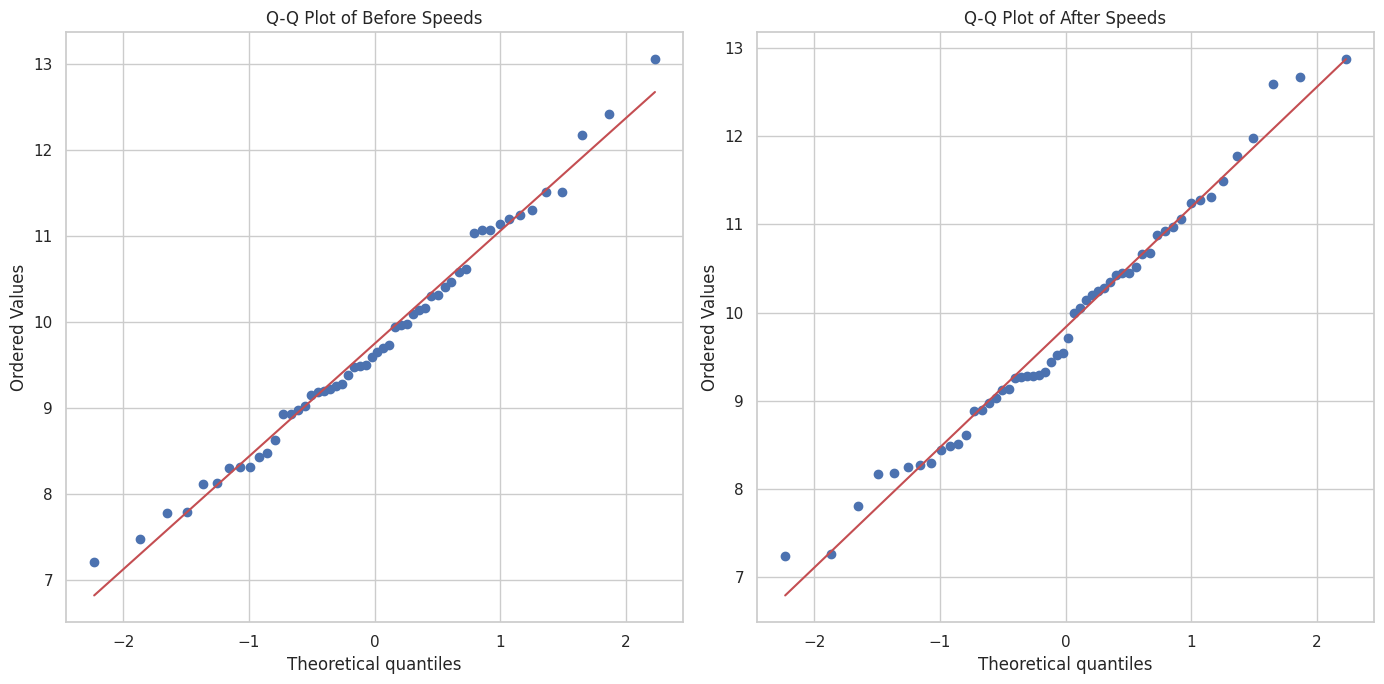

In [95]:
# Shapiro-Wilk Test for normality
shapiro_before = stats.shapiro(before_speeds)
shapiro_after = stats.shapiro(after_speeds)

print(f'Shapiro-Wilk Test Before: {shapiro_before}')
print(f'Shapiro-Wilk Test After: {shapiro_after}')

# Kolmogorov-Smirnov Test for normality
ks_before = stats.kstest(before_speeds, 'norm', args=(np.mean(before_speeds), np.std(before_speeds)))
ks_after = stats.kstest(after_speeds, 'norm', args=(np.mean(after_speeds), np.std(after_speeds)))

print(f'Kolmogorov-Smirnov Test Before: {ks_before}')
print(f'Kolmogorov-Smirnov Test After: {ks_after}')

# Q-Q Plots
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
stats.probplot(before_speeds, dist="norm", plot=plt)
plt.title("Q-Q Plot of Before Speeds")

plt.subplot(1, 2, 2)
stats.probplot(after_speeds, dist="norm", plot=plt)
plt.title("Q-Q Plot of After Speeds")

plt.tight_layout()
plt.show()


## Smaller graphs for paper

In [96]:
def load_speed_data(participant):
    file_path = os.path.join(BASE_FOLDER, participant, SPEED_FILE)
    df = pd.read_csv(file_path, header=None, names=['time', 'speed'])
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df['speed'] = df['speed'] * 3.6  # Convert to km/h from m/s
    return df

# Clean up speed data
def clean_speed_data(df, upper_threshold, lower_threshold):
    df = df[df['speed'] <= upper_threshold]    
    df = df[df['speed'] >= lower_threshold]    
    return df

def plot_speed_data(df, participant):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pd.to_datetime(df['time'], unit='ms'), y=df['speed'], mode='lines', name=f'Participant {participant}'))
    add_time_markers(df, fig, 'speed')
    fig.update_layout(
        title=f'Speed Data for Participant {participant}',
        xaxis_title='Time',
        yaxis_title='Speed in km/h',
        xaxis=dict(tickformat='%H:%M', title_font=dict(size=10)),
        yaxis=dict(title_font=dict(size=10)),
        title_font=dict(size=12),
        width=450,
        height=300,
        margin=dict(l=30, r=30, t=30, b=30)
    )
    fig.show()

def add_time_markers(df, fig, data):
    starting_time = pd.to_datetime(STARTING_TIMESTAMPS[participant], unit='ms')
    fig.add_vline(x=starting_time, line=dict(color='red', dash='dash'))
    # fig.add_annotation(x=starting_time, y=max(df[data]), text='Start', showarrow=True, arrowhead=1, ax=-10, ay=-30, arrowcolor='red')
    for i in range(1, 7):
        marker_time = starting_time + pd.Timedelta(minutes=2 * i)
        fig.add_vline(x=marker_time, line=dict(color='blue', dash='dash'))
        # fig.add_annotation(x=marker_time, y=max(df[data]), text=f'+{2 * i}min', showarrow=True, arrowhead=1, ax=-10, ay=-30, arrowcolor='blue')
    marker_time = starting_time + pd.Timedelta(minutes=15)
    fig.add_vline(x=marker_time, line=dict(color='red', dash='dash'))
    # fig.add_annotation(x=marker_time, y=max(df[data]), text='End', showarrow=True, arrowhead=1, ax=-10, ay=-30, arrowcolor='blue')


# Load and plot data for each participant
speed_dfs = []
for participant in PARTICIPANTS:
    speed_df = load_speed_data(participant)
    cleaned_speed_df = clean_speed_data(speed_df, 20, 5)
    speed_dfs.append(cleaned_speed_df)
    plot_speed_data(cleaned_speed_df, participant)



In [97]:
# Example data
before = negative_before_prompt
after = negative_after_prompt

# Calculate differences
differences = np.subtract(after , before)
print(differences)
# Mean of differences
mean_diff = np.mean(differences)
print(mean_diff)
# Standard deviation of differences
std_diff = np.std(differences, ddof=1)  # ddof=1 for sample standard deviation
print(std_diff)
# Number of pairs
n = len(differences)
print(n)
# Calculate t-statistic
t_stat = mean_diff / (std_diff / np.sqrt(n))
print(t_stat)

[ 1.34690904  0.25199976 -0.24389996  0.51200008 -0.19374527  0.05072743
  0.00140273  0.54196346  0.03236367  0.25328547  0.08099685 -0.70800028
 -0.13200023 -0.189      -0.22945433  0.05599995 -0.10472724  0.14759995]
0.08191228171103636
0.42888860997499806
18
0.8102905301735072
